In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional, Dropout, Conv1D, MaxPooling1D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14369389842794108189,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1654237252832456511
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9923680666
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 5395515177245528659
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10988499764
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
     l

In [2]:
print(len(tf.config.experimental.list_physical_devices("GPU")))

4


In [2]:
pd.set_option('display.max_colwidth', 140)

tweets_text = pd.read_csv("dataset_5.txt", sep='\t', header=None)
tweets_text.columns = ['Text','Label']

print("Out of {} rows, {} are spams, {} are non-spams".format(len(tweets_text),
                                                              len(tweets_text[tweets_text['Label']=='Spam']),
                                                              len(tweets_text[tweets_text['Label']=='Ham'])))

Out of 4566049 rows, 2232663 are spams, 2333386 are non-spams


In [3]:
# Convert labels to numeric format
tweets_text['Label'] = np.where(tweets_text['Label']=='Spam',1,0)

X_train, X_test, y_train, y_test = train_test_split(tweets_text['Text'], tweets_text['Label'], 
                                                    test_size=0.01, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.010101, random_state=2)

In [4]:
# Convert labels to numpy arrays
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

In [5]:
print("Training data: {} ({}%)\nTest data: {} ({}%)\nValidation data: {} ({}%)".format(len(X_train), round((len(X_train)/len(tweets_text))*100), 
                                                                                       len(X_test), round((len(X_test)/len(tweets_text))*100), 
                                                                                       len(X_val), round((len(X_val)/len(tweets_text))*100)))

Training data: 4474727 (98%)
Test data: 45661 (1%)
Validation data: 45661 (1%)


In [6]:
# Train the tokenizer and use that tokenizer to convert sentences into sequences of numbers
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
print("Number of vocabulary: {}".format(len(tokenizer.word_index)))
print(tokenizer.word_index)

Number of vocabulary: 44900
{'<OOV>': 1, 'url': 2, 'usermention': 3, 'retweet': 4, 'new': 5, 'get': 6, 'free': 7, 'day': 8, 'twitter': 9, 'like': 10, 'make': 11, 'good': 12, 'time': 13, 'love': 14, 'one': 15, 'video': 16, 'got': 17, 'know': 18, 'money': 19, 'news': 20, 'want': 21, 'need': 22, 'today': 23, 'see': 24, 'great': 25, 'check': 26, 'work': 27, 'home': 28, 'best': 29, 'way': 30, 'back': 31, 'people': 32, 'think': 33, 'marketing': 34, 'going': 35, 'business': 36, 'post': 37, 'thanks': 38, 'life': 39, 'say': 40, 'look': 41, 'really': 42, 'right': 43, 'show': 44, 'year': 45, 'follow': 46, 'take': 47, 'would': 48, 'world': 49, 'follower': 50, 'game': 51, 'thing': 52, 'live': 53, 'come': 54, 'help': 55, 'night': 56, 'much': 57, 'man': 58, 'let': 59, 'well': 60, 'latest': 61, 'still': 62, 'week': 63, 'site': 64, 'first': 65, 'tweet': 66, 'please': 67, 'job': 68, 'find': 69, 'last': 70, 'friend': 71, 'watch': 72, 'use': 73, 'happy': 74, 'via': 75, 'better': 76, 'tip': 77, 'never': 78

In [7]:
with open('tokenizer_5.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
#Load the tokenizer
with open('tokenizer_5.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

print("Number of vocabulary: {}".format(len(tokenizer.word_index)))

Number of vocabulary: 44900


In [9]:
def text_processing(data, maxlen):
    seq = tokenizer.texts_to_sequences(data)
    seq_pad = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')
    return seq_pad

In [10]:
X_train_seq_padded = text_processing(X_train,20)
X_test_seq_padded = text_processing(X_test,20)
X_val_seq_padded = text_processing(X_val,20)

In [11]:
def model_rnn():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50, mask_zero=True, input_length=max_len))
    model.add(LSTM(32, dropout=0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [43]:
def model_cnn():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50, input_length=max_len))
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(32, return_sequences=False, dropout=0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model   

In [12]:
def plot_graphs(history, metrics, title, epochs):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_'+metrics])
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.xticks(range(0,epochs))
    plt.legend([metrics, 'val_'+metrics], loc='best')
    plt.show()

In [13]:
max_len = 20
model = model_rnn()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 50)            2245050   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,256,763
Trainable params: 2,256,763
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compile the model
tf.random.set_seed(1234)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks list
filepath = 'rnn_5.hdf5'
callbacks_list = [ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True)]

# Train model
batch_size = 512
epochs = 20

with tf.device('/device:GPU:1'):
    history = model.fit(X_train_seq_padded, y_train, batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val_seq_padded, y_val), verbose=1, callbacks=callbacks_list)

Train on 4474727 samples, validate on 45661 samples
Epoch 1/20
4474727/4474727 [==============================] - 309s 69us/step - loss: 0.4880 - accuracy: 0.7810 - val_loss: 0.4574 - val_accuracy: 0.7946

Epoch 00001: val_loss improved from inf to 0.45736, saving model to rnn_5.hdf5
Epoch 2/20
    512/4474727 [..............................] - ETA: 24:36 - loss: 0.4886 - accuracy: 0.7871

/home/students/acct1001_11/anaconda3/envs/pythongpu/lib/python3.6/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


4474727/4474727 [==============================] - 305s 68us/step - loss: 0.4671 - accuracy: 0.7931 - val_loss: 0.4498 - val_accuracy: 0.7996

Epoch 00002: val_loss improved from 0.45736 to 0.44984, saving model to rnn_5.hdf5
Epoch 3/20
4474727/4474727 [==============================] - 305s 68us/step - loss: 0.4591 - accuracy: 0.7974 - val_loss: 0.4452 - val_accuracy: 0.8027

Epoch 00003: val_loss improved from 0.44984 to 0.44524, saving model to rnn_5.hdf5
Epoch 4/20
4474727/4474727 [==============================] - 304s 68us/step - loss: 0.4538 - accuracy: 0.8003 - val_loss: 0.4422 - val_accuracy: 0.8045

Epoch 00004: val_loss improved from 0.44524 to 0.44223, saving model to rnn_5.hdf5
Epoch 5/20
4474727/4474727 [==============================] - 304s 68us/step - loss: 0.4504 - accuracy: 0.8022 - val_loss: 0.4412 - val_accuracy: 0.8040

Epoch 00005: val_loss improved from 0.44223 to 0.44115, saving model to rnn_5.hdf5
Epoch 6/20
4474727/4474727 [==============================] - 3

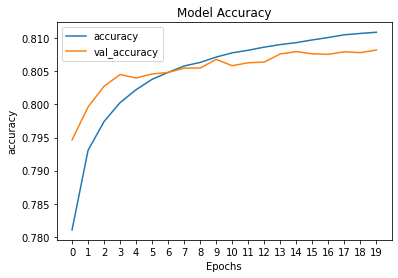

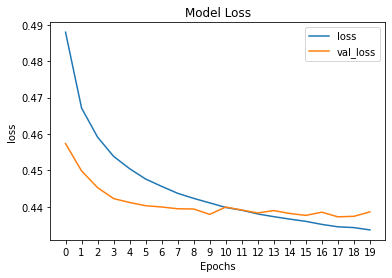

In [15]:
plot_graphs(history, 'accuracy', 'Model Accuracy',20)
plot_graphs(history, 'loss', 'Model Loss',20)

In [16]:
train_loss, train_acc = model.evaluate(X_train_seq_padded, y_train, batch_size=512, verbose=1)

print("Train Accuracy: {}".format(round(train_acc,3)))
print("Train Loss: {}".format(round(train_loss,3)))

4474727/4474727 [==============================] - 145s 32us/step
Train Accuracy: 0.822
Train Loss: 0.404


In [17]:
val_loss, val_acc = model.evaluate(X_val_seq_padded, y_val, batch_size=1, verbose=1)

print("Validation Accuracy: {}".format(round(val_acc,3)))
print("Validation Loss: {}".format(round(val_loss,3)))

45661/45661 [==============================] - 738s 16ms/step
Validation Accuracy: 0.808
Validation Loss: 0.439


In [18]:
test_loss, test_acc = model.evaluate(X_test_seq_padded, y_test, batch_size=1, verbose=1)

print("Test Accuracy: {}".format(round(test_acc,3)))
print("Test Loss: {}".format(round(test_loss,3)))

45661/45661 [==============================] - 739s 16ms/step
Test Accuracy: 0.807
Test Loss: 0.44


In [19]:
y_pred = (model.predict(X_test_seq_padded)>0.5).astype("int32")

print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred),3)))
print("Precision: {}".format(round(precision_score(y_test, y_pred),3)))
print("Recall: {}".format(round(recall_score(y_test, y_pred),3)))
print("F-Measure: {}".format(round(f1_score(y_test, y_pred),3)))

Accuracy: 0.807
Precision: 0.828
Recall: 0.763
F-Measure: 0.794


In [20]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     23404
           1       0.83      0.76      0.79     22257

    accuracy                           0.81     45661
   macro avg       0.81      0.81      0.81     45661
weighted avg       0.81      0.81      0.81     45661



Text(0.5, 1.0, 'Confusion Matrix')

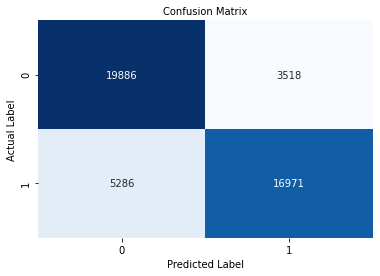

In [21]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cbar=False, cmap=plt.cm.Blues)
plt.ylabel('Actual Label', fontsize=10)
plt.xlabel('Predicted Label', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)

In [22]:
X_test.head()

664956     retweet usermention bizarre turtle turtle post url exist
3012493                           video dragon give away winner url
4444990                               could great web domain detail
3334478                                           bobby lawsuit url
1300482                                                     gon bed
Name: Text, dtype: object

In [23]:
y_pred[0:5]

array([[0],
       [1],
       [1],
       [1],
       [0]], dtype=int32)

In [24]:
y_test[0:5]

array([0, 1, 1, 1, 0])

In [23]:
df_list = list(X_test.values)
df = pd.DataFrame(df_list, columns=["text"])
df["actual"] = y_test
df["predicted"] = y_pred

incorrect = df[df["actual"] != df["predicted"]]

In [24]:
incorrect

,text,actual,predicted
6,mention kiss heart,1,0
10,mention time,1,0
28,around enough know one want go time locator,0,1
31,also already,1,0
36,view new transport protocol increase usefulness performance view platform worked locator,1,0
...,...,...,...
47168,mention mention ga mention,1,0
47170,aha thee,1,0
47178,mention oh,1,0
47179,chewy good beer side long work week,1,0


In [25]:
#export incorrect
incorrect.to_csv('incorrect_4.txt', sep='\t', index=False, header=False)